In [48]:
# load packages


import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [55]:
# read in data


model_df = pd.read_csv("cleaned_atp_data.csv", index_col=0)
model_df.head()

,best_of,grand_slam,surface,seed_diff,rank_points_diff,age,opp_age,avg_fantasy_pts,avg_ace,avg_df,avg_svpt,avg_FirstIn,avg_FirstWon,avg_SecondWon,avg_SvGms,avg_bpSaved,avg_bpFaced,h2h_fantasy_pts,fantasy_pts
0,3,0,Hard,49.0,-2689.0,24.8,22.8,19.0,4.0,3.0,75.0,45.0,32.0,15.0,11.0,4.0,6.0,19.0,25.0
1,3,0,Hard,0.0,250.0,27.2,23.7,19.0,4.0,3.0,75.0,45.0,32.0,15.0,11.0,4.0,6.0,19.0,21.5
2,3,0,Hard,0.0,547.0,24.0,23.2,19.0,4.0,3.0,75.0,45.0,32.0,15.0,11.0,4.0,6.0,19.0,22.0
3,3,0,Hard,43.0,-654.0,26.4,26.6,19.0,4.0,3.0,75.0,45.0,32.0,15.0,11.0,4.0,6.0,19.0,15.0
4,3,0,Hard,-46.0,378.0,25.7,25.7,19.0,4.0,3.0,75.0,45.0,32.0,15.0,11.0,4.0,6.0,19.0,14.5


In [56]:
# dummy variables


# saving numeric variables
num_vars = ['best_of', 'grand_slam', # tourney info
       'seed_diff', 'rank_points_diff', 'age', 'opp_age' # player info
       'avg_fantasy_pts', 'avg_ace', 'avg_df', 'avg_svpt', 'avg_FirstIn', 'avg_FirstWon', 'avg_SecondWon', 'avg_SvGms', 'avg_bpSaved', 'avg_bpFaced', # stat avgs
       'h2h_fantasy_pts'] # h2h avgs

# creating dummy variables for surface, player handedness, opponent handedness
model_df = pd.get_dummies(data=model_df, columns=['surface'])

model_df.head()

,best_of,grand_slam,seed_diff,rank_points_diff,age,opp_age,avg_fantasy_pts,avg_ace,avg_df,avg_svpt,...,avg_SecondWon,avg_SvGms,avg_bpSaved,avg_bpFaced,h2h_fantasy_pts,fantasy_pts,surface_Carpet,surface_Clay,surface_Grass,surface_Hard
0,3,0,49.0,-2689.0,24.8,22.8,19.0,4.0,3.0,75.0,...,15.0,11.0,4.0,6.0,19.0,25.0,0,0,0,1
1,3,0,0.0,250.0,27.2,23.7,19.0,4.0,3.0,75.0,...,15.0,11.0,4.0,6.0,19.0,21.5,0,0,0,1
2,3,0,0.0,547.0,24.0,23.2,19.0,4.0,3.0,75.0,...,15.0,11.0,4.0,6.0,19.0,22.0,0,0,0,1
3,3,0,43.0,-654.0,26.4,26.6,19.0,4.0,3.0,75.0,...,15.0,11.0,4.0,6.0,19.0,15.0,0,0,0,1
4,3,0,-46.0,378.0,25.7,25.7,19.0,4.0,3.0,75.0,...,15.0,11.0,4.0,6.0,19.0,14.5,0,0,0,1


In [57]:
# creating train-test split


X = model_df.drop(['fantasy_pts'], axis = 1)
y = model_df['fantasy_pts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [58]:
# simple linear regression


# fit and predict a linear model
lm = LinearRegression()
lm.fit(X_train, y_train)
y_train_pred = lm.predict(X_train)
y_pred = lm.predict(X_test)

# train MSE
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()

# test MSE
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.19365066452710933
Train MSE: 57.09027223297352

Test R-Squared: 0.19686634679722337
Test MSE: 57.62210801079148


In [59]:
# lasso regression


# lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=1, max_iter=10000)

# fit these models and record accuracy
model.fit(X_train, y_train)

# run lasso on the best alpha value
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)
y_train_pred = lasso_best.predict(X_train)
y_pred = lasso_best.predict(X_test)

# train MSE
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()

# test MSE
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: -0.3981268874148316
Train MSE: 64.48333891141814

Test R-Squared: -0.37677547857589433
Test MSE: 64.39703034164559


In [60]:
# pre-pruned decision tree regressor


# grid search for best parameters
parameters = {'max_depth': [2,4,6,8,10,12],
             'min_samples_split': [2,3,4],
             'min_samples_leaf': [1,2]}
tree = DecisionTreeRegressor()
gscv = GridSearchCV(estimator=tree,param_grid=parameters)
gscv.fit(X_train, y_train)

# fit model with the best parameters
model = gscv.best_estimator_
model.fit(X_train, y_train)

# train MSE
y_train_pred = model.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()

# test MSE
y_pred = model.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.7080828384967411
Train MSE: 28.897853518513067

Test R-Squared: 0.6371884649849884
Test MSE: 36.091623230048086


In [61]:
# random forest regressor


# fit a random forest and predict
rfor = RandomForestRegressor(max_depth=19, max_features=1.0)
rfor.fit(X_train, y_train)


# train MSE
y_train_pred = rfor.predict(X_train)
print("Train R-Squared:", r2_score(y_train_pred, y_train))
print("Train MSE:", mean_squared_error(y_train_pred, y_train))
print()

# test MSE
y_pred = rfor.predict(X_test)
print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))

Train R-Squared: 0.9037238913466461
Train MSE: 10.11081832629627

Test R-Squared: 0.7175368373609198
Test MSE: 27.49436903064074


Test R-Squared: 0.7175368373609198
Test MSE: 27.49436903064074
Test MAE: 3.891002598215589


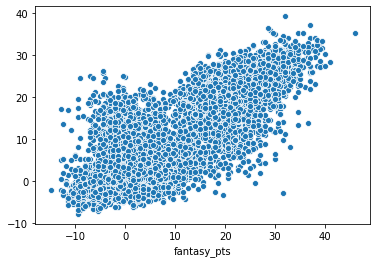

In [64]:
# it is clear that the random forest regressor performs the best
# more analysis

print("Test R-Squared:", r2_score(y_pred, y_test))
print("Test MSE:", mean_squared_error(y_pred, y_test))
print("Test MAE:", mean_absolute_error(y_pred, y_test))
sns.scatterplot(x = y_test, y = y_pred)